In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, LSTM, Embedding, GRU, add, concatenate, Reshape
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

In [4]:
image_path = '../input/flickr8k/Images'
data = pd.read_csv("../input/flickr8k/captions.txt")
data.head()


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [5]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

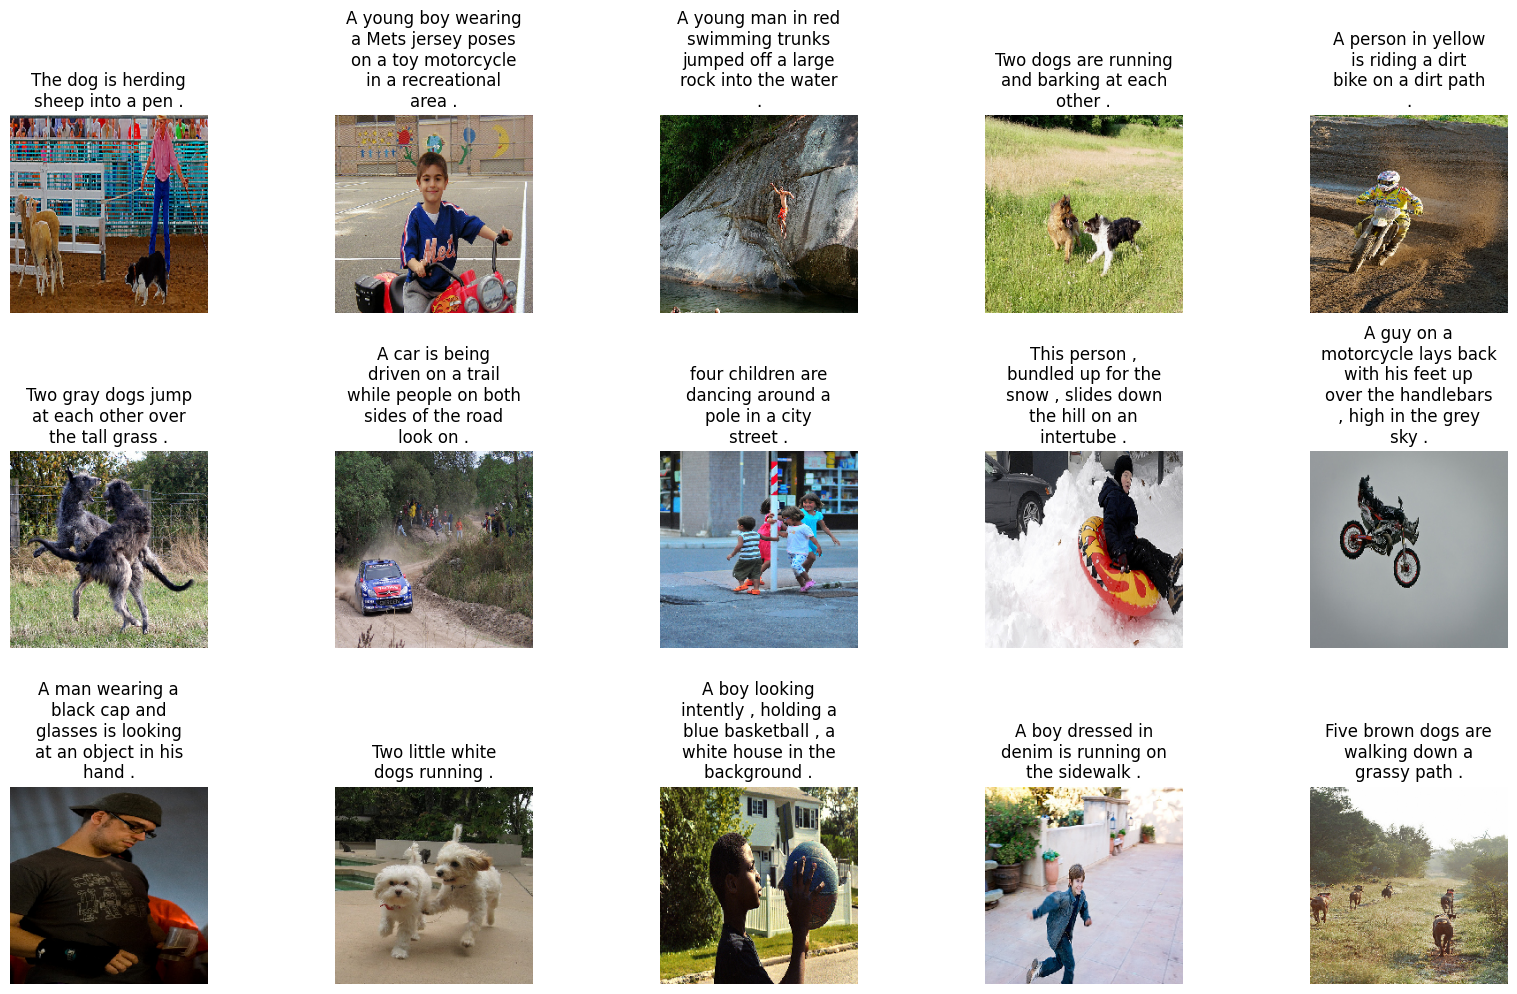

In [6]:
display_images(data.sample(15))

In [7]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [33]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [9]:
from sklearn.model_selection import train_test_split

data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

train_ratio = 0.85
train_data, test_data = train_test_split(data_shuffled, train_size=train_ratio, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_shuffled['caption'])
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in data_shuffled['caption'])

train_sequences = tokenizer.texts_to_sequences(train_data['caption'])
test_sequences = tokenizer.texts_to_sequences(test_data['caption'])

train_images = train_data['image'].unique().tolist()
test_images = test_data['image'].unique().tolist()

train_captions = train_data['caption']
test_captions = test_data['caption']

print(tokenizer.texts_to_sequences([train_captions.iloc[0]]))


[[1, 566, 10, 1, 9, 151, 5, 83, 117]]


In [10]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1730061939.123583     121 service.cc:145] XLA service 0x7fa6980d54a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730061939.123628     121 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730061952.349576     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [12:16<00:00, 10.99it/s]


In [12]:
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [14]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = GRU(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')
caption_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 38, 256)   │  2,174,464 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 39, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 256)       │    394,752 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8494)      │  1,095,726 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,189,614 (15.98 MB)

 Trainable params: 4,189,614 (15.98 MB)

 Non-trainable params: 0 (0.00 B)

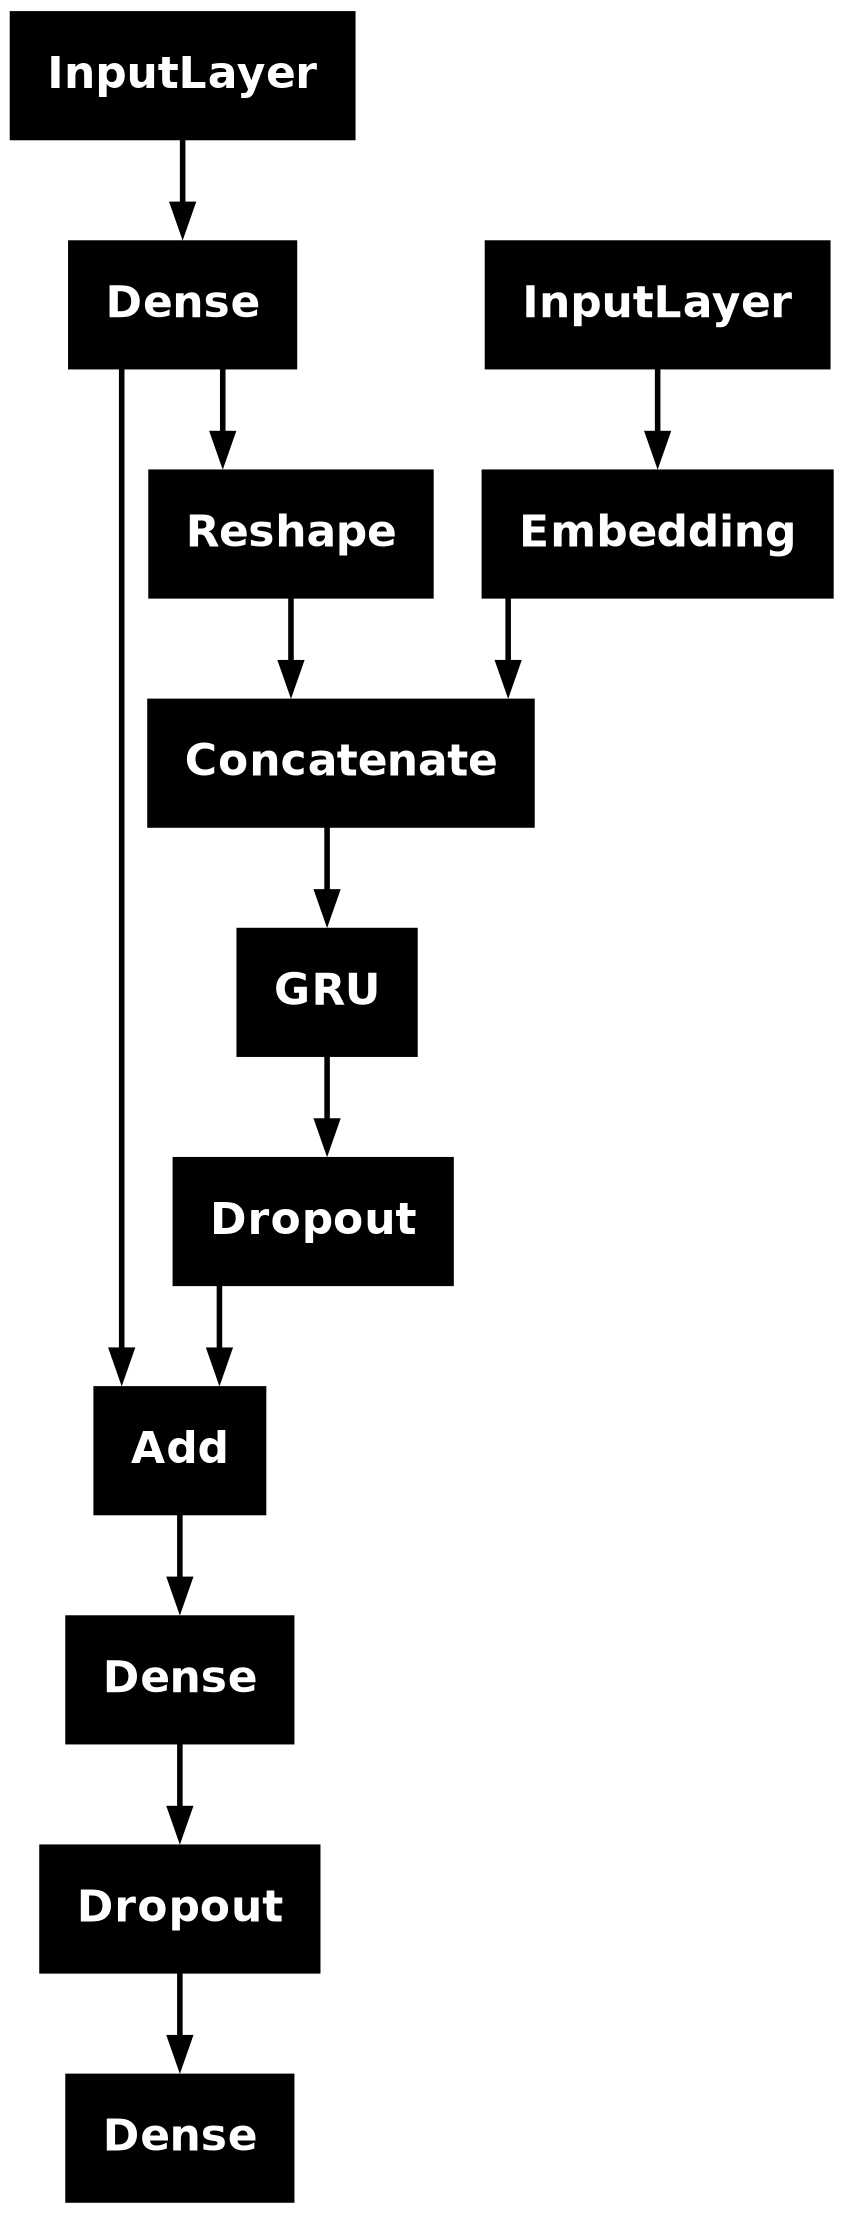

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model)

In [20]:
train_generator = CustomDataGenerator(df=train_data
                                      ,X_col='image',
                                      y_col='caption',
                                      batch_size=64,
                                      directory=image_path,
                                      tokenizer=tokenizer,
                                      vocab_size=vocab_size,
                                      max_length=max_length,
                                      features=features)

validation_generator = CustomDataGenerator(df=test_data,
                                           X_col='image',
                                           y_col='caption',
                                           batch_size=64,
                                           directory=image_path,
                                      tokenizer=tokenizer,
                                           vocab_size=vocab_size,
                                           max_length=max_length,
                                           features=features)

In [21]:
model_name = "model.h5.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [24]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 5.5937
Epoch 1: val_loss improved from inf to 4.13806, saving model to model.h5.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 83s 144ms/step - loss: 5.5913 - val_loss: 4.1381 - learning_rate: 0.0010
Epoch 2/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 4.1809
Epoch 2: val_loss improved from 4.13806 to 3.80685, saving model to model.h5.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 80s 146ms/step - loss: 4.1806 - val_loss: 3.8068 - learning_rate: 0.0010
Epoch 3/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 3.8772
Epoch 3: val_loss improved from 3.80685 to 3.64025, saving model to model.h5.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 79s 146ms/step - loss: 3.8771 - val_loss: 3.6403 - learning_rate: 0.0010
Epoch 4/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 3.6906
Epoch 4: val_loss improved from 3.64025 to 3.53737, saving model to model.h5.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 79s 145ms/step - loss: 3.6906 - val_loss: 3.5374 - learning_rate: 0.0010

In [25]:
# Evaluate the model on the validation data
loss = caption_model.evaluate(validation_generator, verbose=1)

# Print the evaluation results
print("Validation Loss:", loss)


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 3.3824
Validation Loss: 3.358234405517578


In [26]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [38]:
def generate_caption(model, image_name, tokenizer, max_length, features):
    # Get the image feature vector from the features dictionary
    image_feature = features[image_name]

    # Start the caption with the start token
    current_text = 'startseq'
    for _ in range(max_length):
        # Convert the current sequence of words into a sequence of integers
        sequence = tokenizer.texts_to_sequences([current_text])[0]
        # Pad the sequence to the maximum length
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # Predict the next word using the model
        prediction = model.predict([image_feature, sequence], verbose=0)
        # Get the index of the word with the highest probability
        predicted_word_index = np.argmax(prediction)
        # Convert the index back to a word
        predicted_word = index_to_word(predicted_word_index, tokenizer)

        # Stop if the end token is predicted
        if predicted_word == 'endseq':
            break

        # Add the predicted word to the current sequence
        current_text += ' ' + predicted_word

    # Remove the start and end tokens from the generated caption
    generated_caption = current_text.replace('startseq', '').replace('endseq', '').strip()
    return generated_caption



In [39]:
samples = test_data.sample(15)
samples.reset_index(drop=True,inplace=True)


In [40]:
from keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image from the given path
    img = load_img(image_path, target_size=target_size)
    # Convert the image to an array
    img = img_to_array(img)
    # Normalize pixel values to be between 0 and 1
    img = img / 255.0
    # Expand dimensions to match the expected input shape (batch size, height, width, channels)
    img = np.expand_dims(img, axis=0)
    return img


In [42]:
def index_to_word(index, tokenizer):
    # Get the word corresponding to the given index from the tokenizer
    for word, word_index in tokenizer.word_index.items():
        if word_index == index:
            return word
    return None

In [43]:

for idx, sample in samples.iterrows():
    img_path = os.path.join(image_path, sample['image'])
    img = load_and_preprocess_image(img_path)

    generated_caption = generate_caption(caption_model, sample['image'], tokenizer, max_length, features)

    samples.loc[idx, 'predicted_caption'] = generated_caption


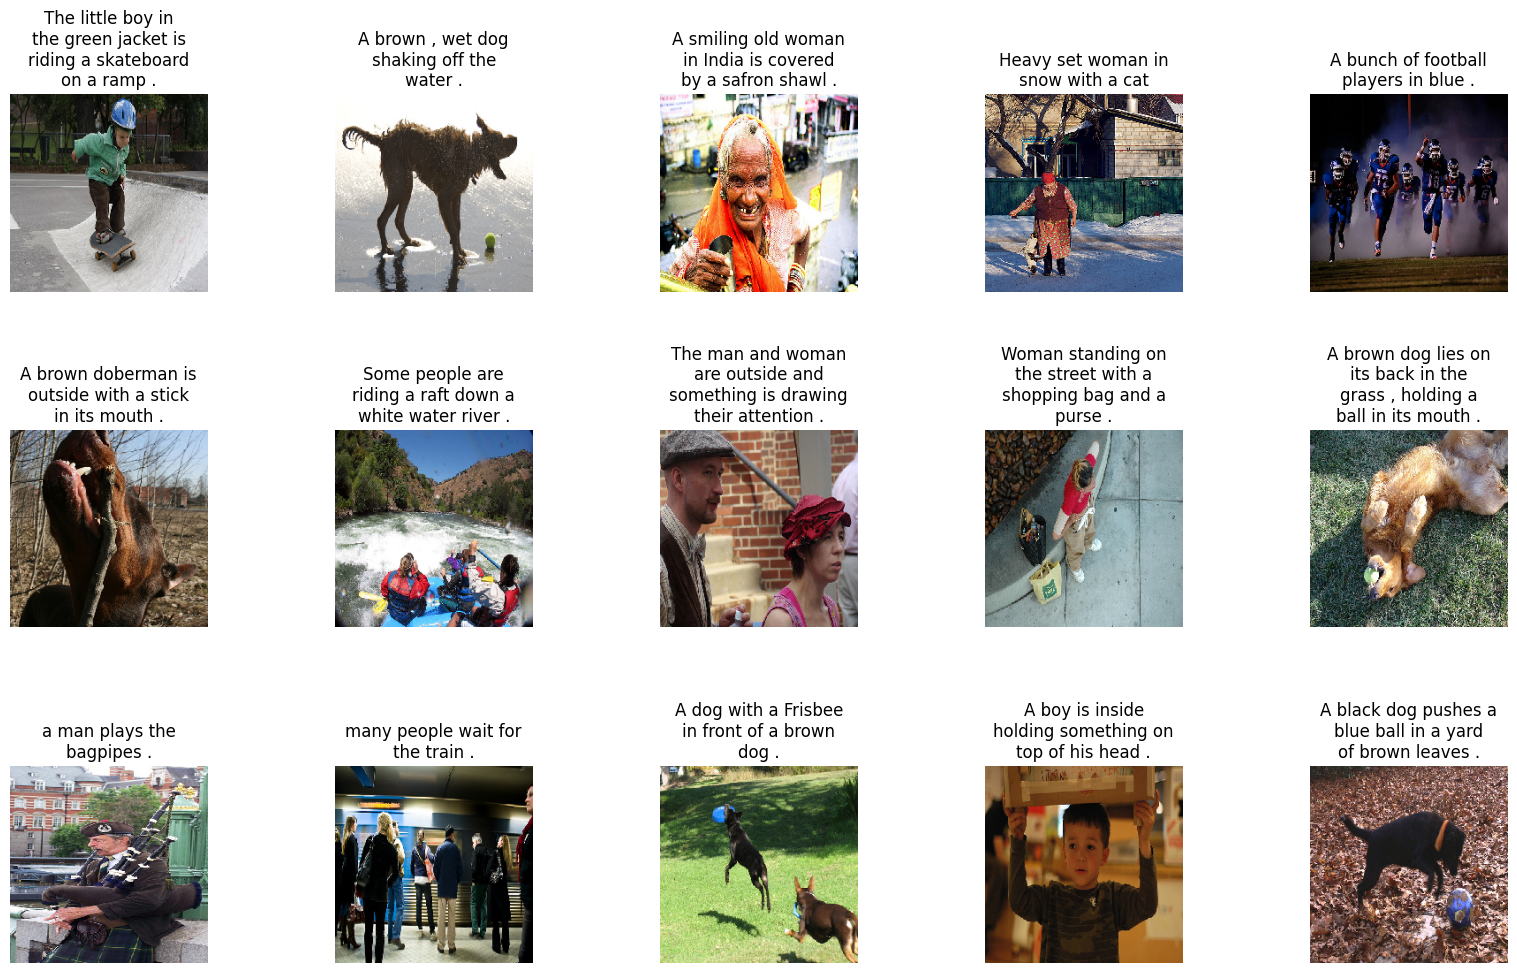

In [44]:
display_images(samples)
